In [117]:
#pandas libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

%run "../notebooks/cargar_df.ipynb"

In [2]:
train = get_train()

In [3]:
test = get_test()

In [4]:
train.head().T

,0,1,2,3,4
ID,27761,27760,27446,16808,16805
Region,EMEA,EMEA,Americas,Americas,Americas
Territory,None,None,NW America,NW America,NW America
"Pricing, Delivery_Terms_Quote_Appr",1,0,0,1,1
"Pricing, Delivery_Terms_Approved",1,0,0,0,0
Bureaucratic_Code_0_Approval,1,0,0,1,1
Bureaucratic_Code_0_Approved,1,0,0,0,0
Bureaucratic_Code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_5
Account_Created_Date,2015-06-16 00:00:00,2015-06-16 00:00:00,2015-04-21 00:00:00,2013-07-27 00:00:00,2013-07-27 00:00:00
Source,None,None,Source_7,Source_11,Source_11


In [5]:
test.head().T

,0,1,2,3,4
ID,6140,6146,6151,6118,6124
Region,EMEA,EMEA,EMEA,EMEA,EMEA
Territory,Germany,Germany,Germany,Germany,Germany
"Pricing, Delivery_Terms_Quote_Appr",1,1,1,1,1
"Pricing, Delivery_Terms_Approved",1,1,1,1,1
Bureaucratic_Code_0_Approval,1,1,1,1,1
Bureaucratic_Code_0_Approved,1,1,1,1,1
Bureaucratic_Code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4
Account_Created_Date,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00,2017-07-05 00:00:00
Source,Source_7,Source_7,Source_7,Source_7,Source_7


In [6]:
train = train[train.Stage.isin(['Closed Won', 'Closed Lost'])].copy()

train.Stage.value_counts()

# Me quedo con los registros con la oportunidad terminada
train.Stage.replace({'Closed Won': 1, 'Closed Lost': 0}, inplace=True)

train.Stage.value_counts()

1    9533
0    7350
Name: Stage, dtype: int64

Busco registros que tengan la misma opportunity id para saber cuales son
las columnas que pueden cambiar el valor

In [7]:
b = train.groupby('Opportunity_ID').ID.count() > 1
b = b[b] # Dejo solo los trues
df = train[train.Opportunity_ID.isin(b.index)]
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
8,24353,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,15600.0,JPY,470400.0,0
9,24355,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,4400.0,JPY,470400.0,0
10,24356,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,6200.0,JPY,470400.0,0
11,24357,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,140000.0,JPY,470400.0,0
12,24358,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,304200.0,JPY,470400.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16940,20827,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10751580.0,USD,21332500.0,0
16941,20830,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10580920.0,USD,21332500.0,0
16942,8781,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-03-25,2016-03-01,Q1,2016,0,EUR,103350.0,EUR,299715.0,1
16943,8786,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-04-08,2016-04-01,Q2,2016,0,EUR,93015.0,EUR,299715.0,1


In [8]:
print('Columnas que cambian de valor dependiendo de la Id en train')

size = df.Opportunity_ID.unique().size
diff_columns = []
for column in df.columns:
    if (df.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en train


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [9]:
print('Columnas que cambian de valor dependiendo de la Id en test')

size = test.Opportunity_ID.unique().size
diff_columns = []
for column in test.columns:
    if (test.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en test


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [10]:
train.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code',
       'Account_Created_Date', 'Source ', 'Billing_Country', 'Account_Name',
       'Opportunity_Name', 'Opportunity_ID', 'Sales_Contract_No',
       'Account_Owner', 'Opportunity_Owner', 'Account_Type',
       'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date',
       'Last_Modified_Date', 'Last_Modified_By', 'Product_Family',
       'Product_Name', 'ASP_Currency', 'ASP', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'TRF', 'Total_Amount_Currency',
       'Total_Amount', 'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount',
       'Stage'],
      dt

In [11]:
grouped_train = train.groupby('Opportunity_ID').agg(\
    {'Region':'first',
     'Territory':'first',
     'Pricing, Delivery_Terms_Quote_Appr':'first',
     'Pricing, Delivery_Terms_Approved':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Account_Created_Date':'first',
     'Source ':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Sales_Contract_No':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Opportunity_Created_Date':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first',
     'Total_Taxable_Amount':'first',
     'Stage':'first'}).reset_index()
grouped_train

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
0,0,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,None,...,None,None,1/30/2016,2016-06-13,Person_Name_18,EUR,EUR,EUR,5272800.0,0
1,1,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,...,None,None,1/20/2016,2016-01-15,Person_Name_20,EUR,EUR,EUR,48230.0,1
2,2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,...,None,None,9/30/2016,2016-09-29,Person_Name_8,USD,USD,USD,83865.6,1
3,3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,0.42,USD,NaT,2018-03-27,Person_Name_8,USD,USD,USD,7421881.5,0
4,4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,0.42,USD,6/2/2017,2018-03-27,Person_Name_8,USD,USD,USD,13357192.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,EMEA,Norway,1,1,0,0,Bureaucratic_Code_4,2013-07-27,Source_9,...,None,None,4/3/2016,2016-04-01,Person_Name_13,EUR,EUR,EUR,401700.0,1
9787,12800,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,None,None,1/15/2016,2016-10-10,Person_Name_13,USD,USD,USD,21332500.0,0
9788,12801,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,None,None,NaT,2016-01-19,Person_Name_13,EUR,EUR,EUR,299715.0,1
9789,12802,Americas,NE America,1,1,1,1,Bureaucratic_Code_4,2015-10-20,None,...,None,None,2/29/2016,2016-01-22,Person_Name_3,USD,USD,USD,0.0,0


In [12]:
grouped_test = test.groupby('Opportunity_ID').agg(\
    {'Region':'first',
     'Territory':'first',
     'Pricing, Delivery_Terms_Quote_Appr':'first',
     'Pricing, Delivery_Terms_Approved':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Account_Created_Date':'first',
     'Source ':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Sales_Contract_No':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Opportunity_Created_Date':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first',
     'Total_Taxable_Amount':'first'}).reset_index()
grouped_test

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount
0,10689,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,2017-07-05,Source_7,...,None,None,None,4/30/2019,2019-04-12,Person_Name_13,EUR,EUR,EUR,367419.0
1,10690,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,2017-07-05,Source_7,...,None,None,None,4/30/2019,2019-04-25,Person_Name_13,EUR,EUR,EUR,757783.5
2,10691,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2019-02-16,Source_9,...,None,None,None,NaT,2019-04-16,Person_Name_9,USD,USD,USD,21037.5
3,10692,Americas,NW America,1,1,1,0,Bureaucratic_Code_2,2013-07-27,Source_11,...,None,None,None,NaT,2019-04-16,Person_Name_8,USD,USD,USD,2169106.5
4,10693,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2018-08-30,Source_9,...,None,None,None,5/12/2019,2019-04-13,Person_Name_64,USD,USD,USD,5752.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,Source_3,...,None,None,None,5/24/2019,2019-04-26,Person_Name_13,USD,USD,USD,147750.0
1563,12365,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,None,...,None,None,None,5/24/2019,2019-04-27,Person_Name_38,USD,USD,USD,45054.9
1564,12366,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,None,...,None,None,None,5/24/2019,2019-04-27,Person_Name_38,USD,USD,USD,100122.0
1565,12367,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,None,...,None,None,None,5/26/2019,2019-04-26,Person_Name_9,USD,USD,USD,143220.0


In [13]:
X = pd.DataFrame({'Opportunity_ID':grouped_train.Opportunity_ID})
y = grouped_train.Stage

In [14]:
serie_losses = pd.Series(dtype='float64')
serie_losses

Series([], dtype: float64)

In [15]:
# Calculo el error

def calculateErrorXgb(X, y, column_name):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.15, random_state=123)

    xgb_reg = xgb.XGBRegressor(objective = 'binary:logistic', \
                               eval_metric='logloss')
    xgb_reg.fit(X_train, y_train)
    preds = xgb_reg.predict(X_test)
    error = log_loss(y_test, preds)
    serie_losses[column_name] = error
    print("Log Loss: %f" % (error))

In [16]:
logistic_losses = pd.Series(dtype='float64')
logistic_losses

Series([], dtype: float64)

In [219]:
# Calculo el error

def calculateErrorLogistic(X, y, column_name): 
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.15, random_state=123)
    
    model = LogisticRegression(random_state=456)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    error = accuracy_score(y_test, preds)
    logistic_losses[column_name] = error
    print("Accuracy Score: %f" % (error))

### Veo por cada feature el error que genera

In [220]:
# Veo si las oportunidades que no necesitaban aprobacion por alguna razon se las aprobo
print('Cantidad de oportunidades aprobadas sin necesidad:\n')
print('Pricing, Delivery_Terms_Quote_Appr:')
print(train[(train['Pricing, Delivery_Terms_Quote_Appr'] == 0)\
      & (train['Pricing, Delivery_Terms_Approved'] == 1)].size)

print('Bureaucratic_Code_0_Approval:')
print(train[(train['Bureaucratic_Code_0_Approval'] == 0)\
      & (train['Bureaucratic_Code_0_Approved'] == 1)].size)

Cantidad de oportunidades aprobadas sin necesidad:

Pricing, Delivery_Terms_Quote_Appr:
0
Bureaucratic_Code_0_Approval:
0


Todos los registros que no necesitaron aprobacion no se aprobaron

In [221]:
df = pd.DataFrame()
df

""


#### Columnas Pricing, Delivery_Terms_Quote_Appr y Pricing, Delivery_Terms_Quote_Appr

In [222]:
z = pd.concat([df,grouped_train['Pricing, Delivery_Terms_Quote_Appr']], \
              axis = 1, sort=False)

In [223]:
z

,"Pricing, Delivery_Terms_Quote_Appr"
0,1
1,0
2,0
3,1
4,1
...,...
9786,1
9787,1
9788,1
9789,1


In [224]:
calculateErrorXgb(z, y, 'Pricing, Delivery_Terms_Quote_Appr')

Log Loss: 0.685320


In [225]:
calculateErrorLogistic(z, y, 'Pricing, Delivery_Terms_Quote_Appr')

Accuracy Score: 0.550034


In [226]:
z = pd.concat([df,grouped_train['Pricing, Delivery_Terms_Approved']], \
              axis = 1, sort=False)

In [227]:
calculateErrorXgb(z, y, 'Pricing, Delivery_Terms_Approved')

Log Loss: 0.685603


In [228]:
calculateErrorLogistic(z, y, 'Pricing, Delivery_Terms_Approved')

Accuracy Score: 0.562968


In [229]:
pricing_ok = grouped_train.agg(lambda x: int(x['Pricing, Delivery_Terms_Quote_Appr'] \
              == x['Pricing, Delivery_Terms_Approved']), axis = 1)
pricing_ok 

0       1
1       1
2       1
3       0
4       0
       ..
9786    1
9787    0
9788    1
9789    1
9790    1
Length: 9791, dtype: int64

In [230]:
# Binaria, es 1 si se necesitaba aprobación y se aprobó o si no la necesitaba
# Es 0 si necesitaba aprobacion y no se aprobo

z = pd.concat([df,pricing_ok], axis = 1, sort=False)

In [231]:
calculateErrorXgb(z, y, 'pricing_aprobada')

Log Loss: 0.651272


In [232]:
calculateErrorLogistic(z, y, 'pricing_aprobada')

Accuracy Score: 0.620830


#### Columna Bureaucratic_Code

In [233]:
z = pd.concat([df,grouped_train['Bureaucratic_Code_0_Approval']], \
              axis = 1, sort=False)
z.Bureaucratic_Code_0_Approval = z.Bureaucratic_Code_0_Approval.astype('int8')

In [234]:
calculateErrorXgb(z, y, 'Bureaucratic_Code_0_Approval')

Log Loss: 0.663914


In [235]:
calculateErrorLogistic(z, y, 'Bureaucratic_Code_0_Approval')

Accuracy Score: 0.622192


In [236]:
z = pd.concat([df,grouped_train['Bureaucratic_Code_0_Approved']], \
              axis = 1, sort=False)
z.Bureaucratic_Code_0_Approved = z.Bureaucratic_Code_0_Approved.astype('int8')

In [237]:
calculateErrorXgb(z, y, 'Bureaucratic_Code_0_Approved')

Log Loss: 0.691748


In [238]:
calculateErrorLogistic(z, y, 'Bureaucratic_Code_0_Approved')

Accuracy Score: 0.530293


In [239]:
bureaucratic_ok = grouped_train.agg(lambda x: int(x['Bureaucratic_Code_0_Approval'] \
              == x['Bureaucratic_Code_0_Approved']), axis = 1)
bureaucratic_ok 

0       1
1       1
2       1
3       0
4       0
       ..
9786    1
9787    1
9788    1
9789    1
9790    1
Length: 9791, dtype: int64

In [240]:
# Binaria, es 1 si se necesitaba aprobación y se aprobó o si no la necesitaba
# Si necesitaba aprobacion y no se aprobo es 0

z = pd.concat([df,bureaucratic_ok], \
              axis = 1, sort=False)

In [241]:
calculateErrorXgb(z, y, 'bureaucratic_ok')

Log Loss: 0.657980


In [242]:
calculateErrorLogistic(z, y, 'bureaucratic_ok')

Accuracy Score: 0.599728


Me fijo si hay diferencia entre transformar la columna bureaucratic code con one-hot-encoder o 
con ordinal-encoder

In [243]:
train.Bureaucratic_Code.value_counts()

Bureaucratic_Code_4    12544
Bureaucratic_Code_5     3782
Bureaucratic_Code_1      261
Bureaucratic_Code_2      242
Bureaucratic_Code_0       51
Bureaucratic_Code_3        2
Bureaucratic_Code_6        1
Name: Bureaucratic_Code, dtype: int64

In [244]:
one_hot_enc_train = pd.get_dummies(grouped_train.Bureaucratic_Code)
one_hot_enc_test = pd.get_dummies(grouped_test.Bureaucratic_Code)

one_hot_enc_train, one_hot_enc_test = one_hot_enc_train\
    .align(one_hot_enc_test, join='left', axis=1)

z = pd.concat([df,one_hot_enc_train], \
              axis = 1, sort=False)

In [245]:
calculateErrorXgb(z, y, 'one_hot_bureaucratic_code')

Log Loss: 0.648564


In [246]:
calculateErrorLogistic(z, y, 'one_hot_bureaucratic_code')

Accuracy Score: 0.628319


In [247]:
grouped_train.Bureaucratic_Code.map(lambda x: x[18:19]).astype('int8')

0       4
1       4
2       4
3       5
4       5
       ..
9786    4
9787    5
9788    4
9789    4
9790    4
Name: Bureaucratic_Code, Length: 9791, dtype: int8

In [248]:
z = pd.concat([df,grouped_train.Bureaucratic_Code.map(lambda x: x[18:19]).astype('int8')],\
              axis = 1, sort=False)

In [249]:
calculateErrorXgb(z, y, 'ordinal_bureaucratic_code')

Log Loss: 0.648941


In [250]:
calculateErrorLogistic(z, y, 'ordinal_bureaucratic_code')

Accuracy Score: 0.620150


#### Paso Account type a one hot encoder

In [251]:
grouped_train['Account_Type'].value_counts()

Account_Type_2    4676
Account_Type_0    3418
Account_Type_5    1445
Account_Type_1     124
None               103
Account_Type_6      17
Account_Type_4       8
Name: Account_Type, dtype: int64

In [252]:
one_hot_enc_train = pd.get_dummies(grouped_train.Account_Type)
one_hot_enc_test = pd.get_dummies(grouped_test.Account_Type)

one_hot_enc_train, one_hot_enc_test = one_hot_enc_train\
    .align(one_hot_enc_test, join='left', axis=1)

z = pd.concat([df,one_hot_enc_train], \
              axis = 1, sort=False)

In [253]:
calculateErrorXgb(z, y, 'one_hot_account_type')

Log Loss: 0.646294


In [254]:
calculateErrorLogistic(z, y, 'one_hot_account_type')

Accuracy Score: 0.612662


In [255]:
grouped_train.Account_Type.mode()

0    Account_Type_2
dtype: object

In [256]:
grouped_train.replace({'None':'Account_Type_2'}).Account_Type\
    .map(lambda x: x[13:14]).value_counts()#.astype('int8')

2    4779
0    3418
5    1445
1     124
6      17
4       8
Name: Account_Type, dtype: int64

In [257]:
u = grouped_train.replace({'None':'Account_Type_2'}).Account_Type\
    .map(lambda x: x[13:14]).astype('int8')
z = pd.concat([df,u], axis = 1, sort=False)

In [258]:
calculateErrorXgb(z, y, 'ordinal_account_type')

Log Loss: 0.649029


In [259]:
calculateErrorLogistic(z, y, 'ordinal_account_type')

Accuracy Score: 0.603812


Feature: Cantidad de ids por oportunidad

In [260]:
train.groupby('Opportunity_ID').ID.count().value_counts()

1     6882
2     1585
3      376
6      268
5      257
4      193
7      103
8       59
9       20
10      18
16       6
12       5
11       5
14       4
13       4
26       2
36       2
18       1
24       1
Name: ID, dtype: int64

In [261]:
c = train.groupby('Opportunity_ID').ID.count()
c

Opportunity_ID
0        1
1        1
2        1
3        1
4        1
        ..
12799    1
12800    2
12801    3
12802    1
12803    1
Name: ID, Length: 9791, dtype: int64

In [262]:
group1 = (c == 1).astype('int8')
group1

Opportunity_ID
0        1
1        1
2        1
3        1
4        1
        ..
12799    1
12800    0
12801    0
12802    1
12803    1
Name: ID, Length: 9791, dtype: int8

In [263]:
group2 = (c == 2).astype('int8')
group2

Opportunity_ID
0        0
1        0
2        0
3        0
4        0
        ..
12799    0
12800    1
12801    0
12802    0
12803    0
Name: ID, Length: 9791, dtype: int8

In [264]:
group3 = (c >= 3).astype('int8')
group3

Opportunity_ID
0        0
1        0
2        0
3        0
4        0
        ..
12799    0
12800    0
12801    1
12802    0
12803    0
Name: ID, Length: 9791, dtype: int8

In [265]:
z = df.copy()
z['G1'] = group1
z['G2'] = group2
z['G3'] = group3

In [266]:
calculateErrorXgb(z, y, 'count_id_3_groups')

Log Loss: 0.684856


In [267]:
calculateErrorLogistic(z, y, 'count_id_3_groups')

Accuracy Score: 0.549353


In [268]:
group1 = (c != 1).astype('int8')
group1

Opportunity_ID
0        0
1        0
2        0
3        0
4        0
        ..
12799    0
12800    1
12801    1
12802    0
12803    0
Name: ID, Length: 9791, dtype: int8

In [269]:
# Es 0 si hay solo un registro por oportunidad, 0 sino
z = df.copy()
z['G1'] = group1

In [270]:
calculateErrorXgb(z, y, 'count_id_1_groups')

Log Loss: 0.686573


In [271]:
calculateErrorLogistic(z, y, 'count_id_1_groups')

Accuracy Score: 0.549353


Feature: menor y/o mayor anio de creacion de oportunidad 

In [272]:
train.groupby('Opportunity_ID').Delivery_Year.min()

Opportunity_ID
0        2016
1        2016
2        2016
3        2018
4        2018
         ... 
12799    2016
12800    2016
12801    2016
12802    2016
12803    2016
Name: Delivery_Year, Length: 9791, dtype: int16

In [273]:
min_year = train.groupby('Opportunity_ID').Delivery_Year.min().reset_index()

z = pd.concat([df, min_year.Delivery_Year], \
              axis = 1, sort=False)

In [274]:
calculateErrorXgb(z, y, 'min_year')

Log Loss: 0.686074


In [275]:
calculateErrorLogistic(z, y, 'min_year')

Accuracy Score: 0.507828


Feature: cantidad de dias activos

In [276]:
# Calculo la cantidad de dias activos que tuvo cada oportunidad
days = grouped_train['Last_Modified_Date'] - grouped_train['Opportunity_Created_Date']

In [277]:
days.dt.days

0       189
1        39
2       296
3       840
4       840
       ... 
9786    119
9787    311
9788     46
9789     48
9790    298
Length: 9791, dtype: int64

In [278]:
z = df.copy()
z['days_elapsed'] = days.dt.days

In [279]:
calculateErrorXgb(z, y, 'days_elapsed')

Log Loss: 0.628464


In [280]:
calculateErrorLogistic(z, y, 'days_elapsed')

Accuracy Score: 0.550034


Feature: dia de la semana de su creacion

In [281]:
week_day = grouped_train['Opportunity_Created_Date'].dt.weekday
week_day

0       0
1       0
2       1
3       1
4       1
       ..
9786    4
9787    4
9788    4
9789    5
9790    5
Name: Opportunity_Created_Date, Length: 9791, dtype: int64

In [282]:
z = df.copy()
z['week_day'] = week_day

In [283]:
calculateErrorXgb(z, y, 'week_day')

Log Loss: 0.691313


In [284]:
calculateErrorLogistic(z, y, 'week_day')

Accuracy Score: 0.510551


Feature: Delivery quarter por numero o por one hot encoder

In [285]:
train.groupby('Opportunity_ID').Delivery_Quarter.first().agg(lambda x: x[1:2]).astype('int8')

Opportunity_ID
0        2
1        1
2        1
3        1
4        1
        ..
12799    2
12800    4
12801    1
12802    2
12803    3
Name: Delivery_Quarter, Length: 9791, dtype: int8

In [286]:
first_quarter = train.groupby('Opportunity_ID').Delivery_Quarter.first()\
                     .agg(lambda x: x[1:2]).astype('int8')

z = pd.concat([df, first_quarter], axis = 1, sort=False)

In [287]:
calculateErrorXgb(z, y, 'Delivery_Quarter')

Log Loss: 0.692001


In [288]:
calculateErrorLogistic(z, y, 'Delivery_Quarter')

Accuracy Score: 0.513274


In [289]:
one_hot_enc_train = pd.get_dummies(first_quarter)
one_hot_enc_test = pd.get_dummies(first_quarter)

one_hot_enc_train, one_hot_enc_test = one_hot_enc_train\
    .align(one_hot_enc_test, join='left', axis=1)

z = pd.concat([df,one_hot_enc_train], axis = 1, sort=False)

In [290]:
calculateErrorXgb(z, y, 'one_hot_Delivery_Quarter')

Log Loss: 0.692001


In [291]:
calculateErrorLogistic(z, y, 'one_hot_Delivery_Quarter')

Accuracy Score: 0.522124


In [292]:
z = df.copy()
col = 'first_quarter'

z[col+'_sin']=np.sin((2*np.pi*first_quarter)/max(first_quarter))
z[col+'_cos']=np.cos((2*np.pi*first_quarter)/max(first_quarter))

z

,first_quarter_sin,first_quarter_cos
Opportunity_ID,,
0,1.224647e-16,-1.000000e+00
1,1.000000e+00,6.123234e-17
2,1.000000e+00,6.123234e-17
3,1.000000e+00,6.123234e-17
4,1.000000e+00,6.123234e-17
...,...,...
12799,1.224647e-16,-1.000000e+00
12800,-2.449294e-16,1.000000e+00
12801,1.000000e+00,6.123234e-17


In [293]:
calculateErrorXgb(z, y, 'Delivery_Quarter_cyclic')

Log Loss: 0.692001


In [294]:
calculateErrorLogistic(z, y, 'Delivery_Quarter_cyclic')

Accuracy Score: 0.503063


Feature: de la columna Month el menor mes y anio

In [295]:
train.Month.dt.month

0        5
1        1
2        1
3        2
4        2
        ..
16942    3
16943    4
16944    3
16945    4
16946    7
Name: Month, Length: 16883, dtype: int64

In [296]:
train['month'] = train.Month.dt.month
train['year'] = train.Month.dt.year

In [297]:
u = train.groupby('Opportunity_ID').agg({'month':'min', 'year':'min'}).reset_index()
u

,Opportunity_ID,month,year
0,0,5,2016
1,1,1,2016
2,2,1,2016
3,3,2,2018
4,4,2,2018
...,...,...,...
9786,12799,4,2016
9787,12800,10,2016
9788,12801,3,2016
9789,12802,4,2016


In [298]:
calculateErrorXgb(u, y, 'Month: month and year')

Log Loss: 0.522921


In [299]:
calculateErrorLogistic(z, y, 'Month: month and year')

Accuracy Score: 0.503063


Feature: cantidad de nulos por columna

In [300]:
# Me fijo cuantos null hay por columnas
print('Cantidad de nulos por columna')
grouped_train.replace({'None':np.NaN}).isna().sum()

Cantidad de nulos por columna


Opportunity_ID                           0
Region                                   0
Territory                             1851
Pricing, Delivery_Terms_Quote_Appr       0
Pricing, Delivery_Terms_Approved         0
Bureaucratic_Code_0_Approval             0
Bureaucratic_Code_0_Approved             0
Bureaucratic_Code                        0
Account_Created_Date                     0
Source                                4874
Billing_Country                         26
Account_Name                             0
Opportunity_Name                         0
Sales_Contract_No                     4525
Account_Owner                            0
Opportunity_Owner                        0
Account_Type                           103
Opportunity_Type                         0
Quote_Type                               0
Delivery_Terms                           0
Opportunity_Created_Date                 0
Brand                                 9122
Product_Type                          9137
Size       

In [301]:
#z = df.copy()
#z['has_source'] = (grouped_train['Source '] == 'None').astype('int8')
#z['has_brand'] = (grouped_train['Brand'] == 'None').astype('int8')
#z['has_product_Type'] = (grouped_train['Product_Type'] == 'None').astype('int8')
#z['has_size'] = (grouped_train['Size'] == 'None').astype('int8')
#z['has_product_Category_B'] = (grouped_train['Product_Category_B'] == 'None').astype('int8')
#z['has_price'] = (grouped_train['Price'] == 'None').astype('int8')
#z['has_currency'] = (grouped_train['Currency'] == 'None').astype('int8')
#z

In [302]:
columnas = ['Source ', 'Sales_Contract_No', 'Brand', 'Product_Type', \
            'Size', 'Product_Category_B', 'Price', 'Currency']

# Paso las columnas con muchos nulos a binarias
for col in columnas:
    z = df.copy()
    col_name = 'has_' + str(col)
    z[col_name] = (grouped_train[col] == 'None').astype('int8')
    print('\n' + col_name + ' error xgboost')
    calculateErrorXgb(z, y, col_name)
    print(col_name + ' error logistic')
    calculateErrorLogistic(z, y, col_name)



has_Source  error xgboost
Log Loss: 0.693382
has_Source  error logistic
Accuracy Score: 0.507828

has_Sales_Contract_No error xgboost
Log Loss: 0.181198
has_Sales_Contract_No error logistic
Accuracy Score: 0.954391

has_Brand error xgboost
Log Loss: 0.637611
has_Brand error logistic
Accuracy Score: 0.582029

has_Product_Type error xgboost
Log Loss: 0.640351
has_Product_Type error logistic
Accuracy Score: 0.578625

has_Size error xgboost
Log Loss: 0.641972
has_Size error logistic
Accuracy Score: 0.576583

has_Product_Category_B error xgboost
Log Loss: 0.639801
has_Product_Category_B error logistic
Accuracy Score: 0.579306

has_Price error xgboost
Log Loss: 0.643052
has_Price error logistic
Accuracy Score: 0.575221

has_Currency error xgboost
Log Loss: 0.647882
has_Currency error logistic
Accuracy Score: 0.569095


Me fijo cuales son las columnas categoricas

In [303]:
categorical_cols = ['Region', 'Territory', 'Bureaucratic_Code', 'Billing_Country', \
                    'Account_Name', 'Opportunity_Name', 'Account_Owner', \
                    'Opportunity_Owner', 'Account_Type', 'Opportunity_Type', \
                    'Quote_Type', 'Delivery_Terms', 'Last_Modified_By', 'Product_Family', \
                    'Product_Name', 'ASP_Currency', 'Delivery_Quarter', \
                    'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount' ]

for col in categorical_cols:
    print('\nColumna', col, ': ')
    print('\tValores unicos: ', train[col].nunique())
print()


Columna Region : 
	Valores unicos:  5

Columna Territory : 
	Valores unicos:  75

Columna Bureaucratic_Code : 
	Valores unicos:  7

Columna Billing_Country : 
	Valores unicos:  79

Columna Account_Name : 
	Valores unicos:  1620

Columna Opportunity_Name : 
	Valores unicos:  9791

Columna Account_Owner : 
	Valores unicos:  48

Columna Opportunity_Owner : 
	Valores unicos:  53

Columna Account_Type : 
	Valores unicos:  7

Columna Opportunity_Type : 
	Valores unicos:  25

Columna Quote_Type : 
	Valores unicos:  2

Columna Delivery_Terms : 
	Valores unicos:  9

Columna Last_Modified_By : 
	Valores unicos:  53

Columna Product_Family : 
	Valores unicos:  225

Columna Product_Name : 
	Valores unicos:  446

Columna ASP_Currency : 
	Valores unicos:  5

Columna Delivery_Quarter : 
	Valores unicos:  4

Columna Total_Taxable_Amount_Currency : 
	Valores unicos:  5

Columna Total_Taxable_Amount : 
	Valores unicos:  7052



In [304]:
for col in categorical_cols:
    print('\n' + col)
    print(train[col].value_counts())
print()


Region
Japan          4869
EMEA           4660
Americas       3933
APAC           3251
Middle East     170
Name: Region, dtype: int64

Territory
None               4981
Germany            1682
NW America         1560
Australia          1202
India               807
                   ... 
Saudi Arabia          1
Solomon Islands       1
Slovenia              1
Czech Republic        1
Lebanon               0
Name: Territory, Length: 76, dtype: int64

Bureaucratic_Code
Bureaucratic_Code_4    12544
Bureaucratic_Code_5     3782
Bureaucratic_Code_1      261
Bureaucratic_Code_2      242
Bureaucratic_Code_0       51
Bureaucratic_Code_3        2
Bureaucratic_Code_6        1
Name: Bureaucratic_Code, dtype: int64

Billing_Country
Japan            4856
United States    3790
Germany          1977
Australia        1165
India             671
                 ... 
Kenya               1
Chile               1
Colombia            1
Peru                1
Oman                0
Name: Billing_Country, Length

#### Region: one hot encoder

In [305]:
one_hot_enc_train = pd.get_dummies(grouped_train.Region)
one_hot_enc_test = pd.get_dummies(grouped_test.Region)

one_hot_enc_train, one_hot_enc_test = one_hot_enc_train\
    .align(one_hot_enc_test, join='left', axis=1)

z = pd.concat([df,one_hot_enc_train], axis = 1, sort=False)

In [306]:
calculateErrorXgb(z, y, 'one_hot_Region')

Log Loss: 0.673373


In [307]:
calculateErrorLogistic(z, y, 'one_hot_Region')

Accuracy Score: 0.583390


#### Columna Quote_Type

In [308]:
grouped_train.Quote_Type.value_counts()

Non Binding    9661
Binding         130
Name: Quote_Type, dtype: int64

In [309]:
z = df.copy()
z['Quote_Type'] = (grouped_train.Quote_Type == 'Binding').astype('int8')

In [310]:
calculateErrorXgb(z, y, 'Quote_Type')

Log Loss: 0.693265


In [311]:
calculateErrorLogistic(z, y, 'Quote_Type')

Accuracy Score: 0.507828


In [312]:
serie_losses.sort_values()

has_Sales_Contract_No                 0.181198
Month: month and year                 0.522921
days_elapsed                          0.628464
has_Brand                             0.637611
has_Product_Category_B                0.639801
has_Product_Type                      0.640351
has_Size                              0.641972
has_Price                             0.643052
one_hot_account_type                  0.646294
has_Currency                          0.647882
one_hot_bureaucratic_code             0.648564
ordinal_bureaucratic_code             0.648941
ordinal_account_type                  0.649029
pricing_aprobada                      0.651272
bureaucratic_ok                       0.657980
Bureaucratic_Code_0_Approval          0.663914
one_hot_Region                        0.673373
count_id_3_groups                     0.684856
Pricing, Delivery_Terms_Quote_Appr    0.685320
Pricing, Delivery_Terms_Approved      0.685603
min_year                              0.686074
count_id_1_gr

In [313]:
logistic_losses.sort_values()

Month: month and year                 0.503063
Delivery_Quarter_cyclic               0.503063
Quote_Type                            0.507828
has_Source                            0.507828
min_year                              0.507828
week_day                              0.510551
Delivery_Quarter                      0.513274
one_hot_Delivery_Quarter              0.522124
Bureaucratic_Code_0_Approved          0.530293
count_id_3_groups                     0.549353
count_id_1_groups                     0.549353
days_elapsed                          0.550034
Pricing, Delivery_Terms_Quote_Appr    0.550034
Pricing, Delivery_Terms_Approved      0.562968
has_Currency                          0.569095
has_Price                             0.575221
has_Size                              0.576583
has_Product_Type                      0.578625
has_Product_Category_B                0.579306
has_Brand                             0.582029
one_hot_Region                        0.583390
bureaucratic_

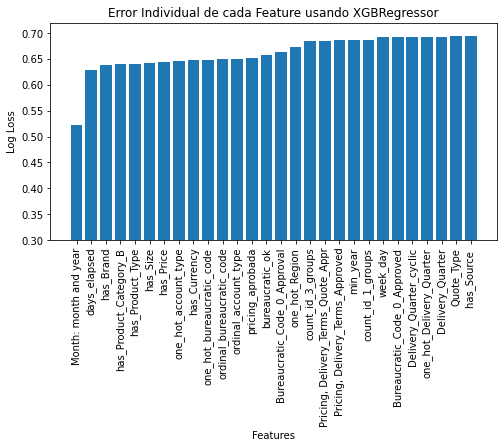

In [314]:
g = serie_losses.sort_values().drop('has_Sales_Contract_No')
plt.figure(figsize=(8,4))
plt.bar(g.index, g)
plt.xlabel('Features')
plt.ylabel('Log Loss')
plt.xticks(rotation=90)
plt.ylim(0.3,0.72)
plt.title('Error Individual de cada Feature usando XGBRegressor')
plt.show()

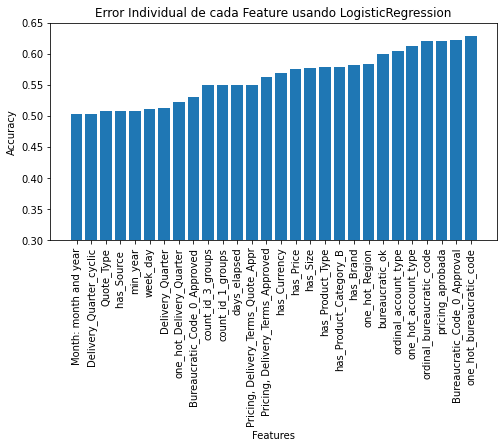

In [315]:
g = logistic_losses.sort_values().drop('has_Sales_Contract_No')
plt.figure(figsize=(8,4))
plt.bar(g.index, g)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.ylim(0.3,0.65)
plt.title('Error Individual de cada Feature usando LogisticRegression')
plt.show()